In [26]:
import csv
import glob
import os
import re

In [27]:
from collections import defaultdict

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
from ete3 import Tree

In [30]:
tree = Tree("data/tree/time_tree.nw")

In [31]:
age2desc = dict()

In [32]:
for node in tree.traverse('postorder'):
    node_name = node.name

    if node.is_leaf():
        continue

    _, age = node.get_farthest_leaf()
    age2desc[age] = set(node.get_leaf_names())

In [33]:
ss_score = {'5': defaultdict(dict), '3': defaultdict(dict)}

In [34]:
for fp in glob.iglob("data/homology/ss/scores/*.csv"):
    chrom, p = os.path.basename(fp).removesuffix(".csv").split("_")

    with open(fp, 'r') as f:
        reader = csv.reader(f)
        _, *names = next(reader)

        for row in reader:
            pos, *scores = row

            # `pos` is the 100-bp range that we search, so I update it to
            # be the position of the exon-intron junciton.
            chrom, *pos = re.split('[:-]', pos)
            beg, end, strand = map(int, pos)

            hsap_ss = f"{chrom}:{beg + 50}:{strand}"

            for name, score in zip(names, scores):
                ss_score[p][hsap_ss][name] = float(score) if score != "-" else "-"

In [35]:
long_data1 = list()
long_data2 = list()

In [36]:
with open("../data/homology/ss/out/origin.csv", 'r') as f:
    reader = csv.reader(f)
    next(reader)

    for row in reader:
        gene, meta_exon, p, ss, hsap_score, gain_ages, loss_ages, pos_group, neg_group, tree_size, _ = row

        if ";" in gain_ages and int(tree_size) > 3:
            hsap_score = float(hsap_score)

            pos_group = set(pos_group.split(";"))
            neg_group = set(neg_group.split(";"))

            leaves = set()
            ages = set()

            for age in gain_ages.split(";"):
                if "_" in age:
                    leaves.add(age)
                else:
                    ages.add(float(age))

            long_data1.append({
                'p': p,
                'score': float(hsap_score),
                'species': "hsap",
            })

            long_data2.append({
                'p': p,
                'score': float(hsap_score),
                'species': "hsap",
            })

            for name in leaves:
                if name == "homo_sapiens":
                    continue

                score = ss_score[p][ss][name]
                long_data1.append({
                    'p': p,
                    'score': ss_score[p][ss][name],
                    'species': "other",
                })

            for age in ages:
                names = age2desc[age] & pos_group

                if "homo_sapiens" in names:
                    continue

                for name in names:
                    score = ss_score[p][ss][name]
                    long_data2.append({
                        'p': p,
                        'score': ss_score[p][ss][name],
                        'species': "other",
                    })

In [37]:
frame1 = pd.DataFrame(long_data1)
frame2 = pd.DataFrame(long_data2)

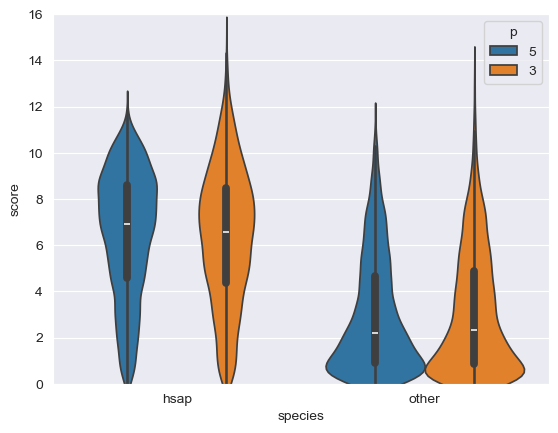

In [38]:
sns.violinplot(frame1, x='species', y='score', hue='p')
_ = plt.ylim(0, 16)

plt.savefig("figs/supp1c_1.pdf")

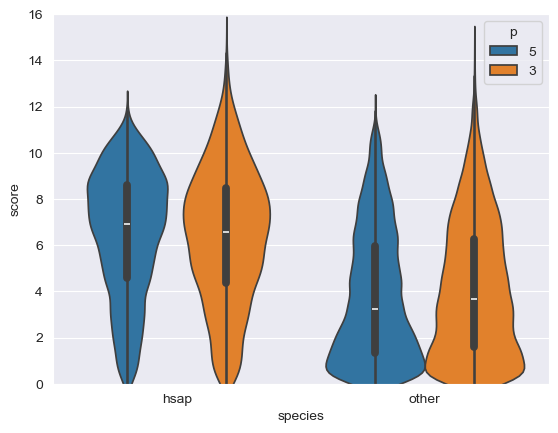

In [39]:
sns.violinplot(frame2, x='species', y='score', hue='p')
_ = plt.ylim(0, 16)

plt.savefig("figs/supp1c_2.pdf")